# Exploring sales datasets using SQL

The goal of this project is to explore the data of two related datasets containing information about the sales and the stores of Rossman, a German drug store chain. Through joining, grouping, plotting, and statistical inference, I try to find interesting insights.

1. Importing libraries;
2. Loading and first exploration of datasets;
3. Moving to SQL tables
4. EDA and hypothesis testing
5. Time-series analysis

Source: https://www.kaggle.com/competitions/rossmann-store-sales/data?select=store.csv

#### 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

import datetime
from dateutil.relativedelta import relativedelta

sns.set_theme(style="whitegrid")

#### 2. Loading and first exploration of datasets

In [2]:
sales = pd.read_csv('sales_data.csv')

C:\Users\roank\BTS\anaconda3\envs\DSF\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# I take a quick look at the data, and see several interesting features related to dates and promos.

sales.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# A warning told me to take a look at column number 7 due to mixed dtypes.

sales.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [5]:
# I notice that for 'no holiday' there are both 0s in numeric and string format. I replace and then map them. 

sales.StateHoliday = np.where(sales.StateHoliday.isin(['0',0]), 'n', sales.StateHoliday)

holidays = {'a':'public holiday','b':'Easter holiday','c':'Christmas', 'n':'None'}
sales.StateHoliday = sales.StateHoliday.map(holidays)
print(sales.StateHoliday.unique())

sales.StateHoliday = sales.StateHoliday.astype('category')
print(sales.StateHoliday.dtype)

['None' 'public holiday' 'Easter holiday' 'Christmas']
category


In [6]:
# Loading and a quick load at the second dataset

stores = pd.read_csv('store.csv')
stores.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
# I change the Assortment categories, so it is clearer (StoreType has no further information)

assortment = {'a':'basic','b':'extra','c':'extended'}
stores.Assortment =stores.Assortment.map(assortment)
print(stores.Assortment.unique())
stores.Assortment =stores.Assortment.astype('category')
print(stores.Assortment.dtype)

['basic' 'extended' 'extra']
category


#### 3. Moving to SQL tables

In [15]:
engine = create_engine('sqlite://')
conn = engine.connect()

In [16]:
# Pandas has a quick function to switch to SQL, but in this case I use SQL statements
## I define the columns, setting NOT NULL for certain columns, setting a PRIMARY KEY and a FOREIGN KEY

conn.execute(""" CREATE TABLE IF NOT EXISTS sales(
                    Id INTEGER PRIMARY KEY,
                    store Integer NOT NULL,
                    Day_of_week Integer NOT NULL,
                    Date Date NOT NULL,
                    Sales Float NOT NULL,
                    Customers Integer NOT NULL,
                    Open Boolean NOT NULL,
                    Promo Boolean NOT NULL,
                    StateHoliday String(20) NOT NULL,
                    SchoolHoliday Boolean NOT NULL,
                    FOREIGN KEY (store) REFERENCES stores(store))
                """)

conn.execute(""" CREATE TABLE IF NOT EXISTS stores(
                    store INTEGER PRIMARY KEY,
                    store_type INTEGER NOT NULL,
                    assortment STRING(10) NOT NULL,
                    competition_distance FLOAT,
                    competition_open_since DATE,
                    promo2 BOOLEAN DEFAULT(NULL),
                    promo2since DATE DEFAULT(NULL),
                    promo_interval STRING(32))
                """)

In [17]:
print(engine.table_names())

['sales', 'stores']


C:\Users\roank\AppData\Local\Temp/ipykernel_3364/1043810782.py:1: SADeprecationWarning: The Engine.table_names() method is deprecated and will be removed in a future release.  Please refer to Inspector.get_table_names(). (deprecated since: 1.4)
  print(engine.table_names())


In [18]:
for i in range(sales.shape[0]):
    store, day, date, sales_, customers, open_, promo, state_hol, school_hol = sales.iloc[i,:].values
    if state_hol == 'None': state_hol = 0
        
    records = store, day, date, sales_, customers, open_, promo, state_hol, school_hol
    
    conn.execute("""INSERT INTO sales (store, day_of_week, Date, Sales, Customers, Open, Promo,
                                        StateHoliday, SchoolHoliday)
                    VALUES {}""".format(records))

In [19]:
# A quick check to see if inserts were correctly done

rs = conn.execute("""SELECT * FROM sales LIMIT 5""")
rs.fetchall()

[(1, 1, 5, '2015-07-31', 5263.0, 555, 1, 1, 0, 1),
 (2, 2, 5, '2015-07-31', 6064.0, 625, 1, 1, 0, 1),
 (3, 3, 5, '2015-07-31', 8314.0, 821, 1, 1, 0, 1),
 (4, 4, 5, '2015-07-31', 13995.0, 1498, 1, 1, 0, 1),
 (5, 5, 5, '2015-07-31', 4822.0, 559, 1, 1, 0, 1)]

In [37]:
for i in range(stores.shape[0]):
    store, store_type, assortment, competition_distance, competition_open_month,\
    competition_open_year, promo2, promo2sincew, promo2sincey, promo_interval = stores.iloc[i,:].values    
    
    # I combine the month and year in one feature so the date is one clear variable
    try:
        competition_open_since = str(int(competition_open_year)) + '-' + str(int(competition_open_month)) + '-' + '01'
    # I turn nans to nulls so the table takes them
    except:
        competition_open_since = 0
        
    # Idem
    if np.isnan(competition_distance): competition_distance =0
        
    # I again combine the dates, also turning nans to 0 if there was no 'promo 2'    
    if promo2 ==1: 
        promo2since = str(datetime.date(int(promo2sincey), 1, 1) + relativedelta(weeks=+promo2sincew))
    else:
        promo2since = 0
        promo_interval = 0
        
    records = store, store_type, assortment, competition_distance, competition_open_since,\
              promo2,promo2since,promo_interval
    
    conn.execute("""INSERT INTO stores (store, store_type, assortment, competition_distance, competition_open_since,
                                        promo2, promo2since, promo_interval)
                    VALUES {}""".format(records))

In [38]:
# A quick check to see if inserts were correctly done

rs = conn.execute("""SELECT * FROM stores LIMIT 5""")
rs.fetchall()

[(1, 'c', 'basic', 1270.0, '2008-9-01', 0, 0, 0),
 (2, 'a', 'basic', 570.0, '2007-11-01', 1, '2010-04-02', 'Jan,Apr,Jul,Oct'),
 (3, 'a', 'basic', 14130.0, '2006-12-01', 1, '2011-04-09', 'Jan,Apr,Jul,Oct'),
 (4, 'c', 'extended', 620.0, '2009-9-01', 0, 0, 0),
 (5, 'a', 'basic', 29910.0, '2015-4-01', 0, 0, 0)]

In [39]:
rs = conn.execute("""SELECT sql FROM sqlite_master WHERE name='sales'""")
for i in rs.fetchall()[0]:
    print(i)

CREATE TABLE sales(
                    Id INTEGER PRIMARY KEY,
                    store Integer NOT NULL,
                    Day_of_week Integer NOT NULL,
                    Date Date NOT NULL,
                    Sales Float NOT NULL,
                    Customers Integer NOT NULL,
                    Open Boolean NOT NULL,
                    Promo Boolean NOT NULL,
                    StateHoliday String(20) NOT NULL,
                    SchoolHoliday Boolean NOT NULL,
                    FOREIGN KEY (store) REFERENCES stores(store))


#### 4. EDA and hypothesis testing

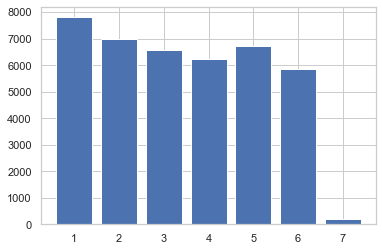

In [40]:
rs = conn.execute("""SELECT Day_of_week , AVG(Sales) as mean_sales FROM sales
                     GROUP BY Day_of_week """)
results = rs.fetchall()
plt.bar(height = dict(results).values(),x = dict(results).keys());

A quick check on the dates, shows that they counted Mondays as 1 and Sundays as 7.

The barplot shows that Sundays amount for the fewest sales. This is not unexcepted, as (certain) Rossman stores are closed on Sundays.\
Regarding the other days, there seem to be some differences, with Monday being the best day; possibly with people picking up medicines for the coming week.\
Let's have a closer look:

In [41]:
day_sales = conn.execute("""SELECT Day_of_week, Sales, StateHoliday,SchoolHoliday  FROM Sales;""")
day_sales = day_sales.fetchall()

In [42]:
df_sales = pd.DataFrame(day_sales, columns = ['day','sales','stHoliday','scHoliday'])

In [43]:
df_sales.groupby('day')['sales'].describe()

,count,mean,std,min,25%,50%,75%,max
day,,,,,,,,
1,144730.0,7809.044510,4016.526273,0.0,5235.00,7310.0,9972.0,41551.0
2,145664.0,7005.244467,3142.039607,0.0,4904.00,6463.0,8491.0,34692.0
3,145665.0,6555.884138,2944.377501,0.0,4718.00,6133.0,7926.0,33151.0
4,145845.0,6247.575913,3209.806360,0.0,4536.00,6020.0,7792.0,38367.0
5,145845.0,6723.274305,3101.006008,0.0,4975.00,6434.0,8206.0,38722.0
6,144730.0,5847.562599,2873.985615,0.0,3899.25,5410.0,7220.0,31683.0
7,144730.0,204.183189,1613.243517,0.0,0.00,0.0,0.0,37376.0


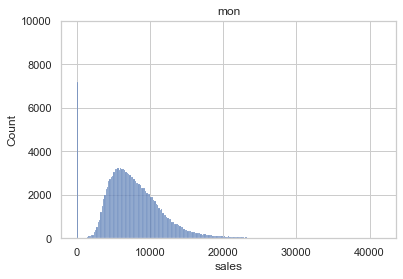

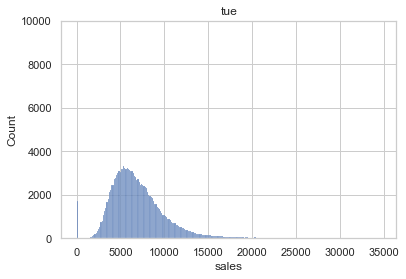

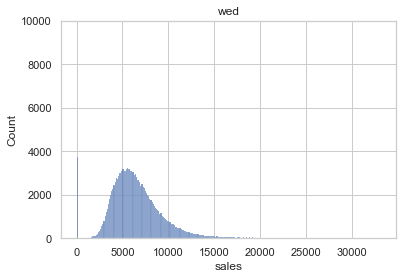

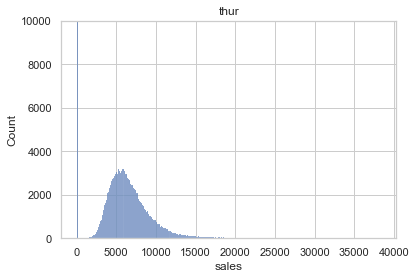

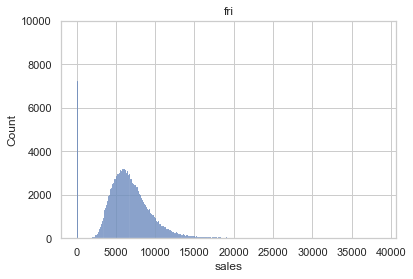

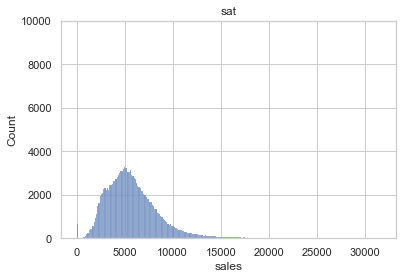

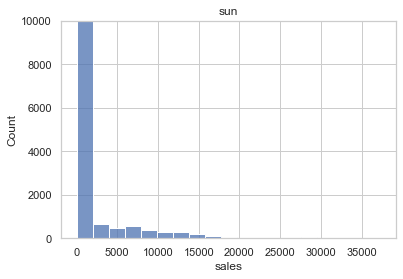

In [44]:
day_map = {1:'mon',2:'tue',3:'wed',4:'thur',5:'fri',6:'sat',7:'sun'}

for day in [1,2,3,4,5,6,7]:
    sns.histplot(data = df_sales[df_sales['day']==day]['sales'])
    plt.ylim([0,10000])
    plt.title(day_map[day])
    plt.show()

We see that all days (except Sundays) show a bell shape, which is likely given the large amount of data, but also a skew towards higher sales. The latter makes sense for sales data, as it's capped at 0 but there's no upper limit. For all days there are a lot of entries with sales equal to zero. This is likely due to holidays and other closed days:

In [45]:
sales_no_hols = conn.execute("""SELECT Day_of_week, Sales, StateHoliday,SchoolHoliday, Date, Store  FROM Sales
                                WHERE StateHoliday == 0 
                                AND SchoolHoliday ==0
                                AND Open == 1;""").fetchall()

In [46]:
df_sales_no_hols = pd.DataFrame(sales_no_hols, columns = ['day','sales','stHoliday','scHoliday', 'date', 'store'])

filter_ = (df_sales_no_hols['sales']==0) & (df_sales_no_hols['day']!=7)

for day in [1,2,3,4,5,6,7]:
    print(day_map[day],df_sales_no_hols['day'][filter_].count())

mon 42
tue 42
wed 42
thur 42
fri 42
sat 42
sun 42


It seems this was mostly correct. Weirdly enough there are 42 entries for all the days where sales where 0.

In [47]:
df_sales_no_hols[filter_].head(5)

,day,sales,stHoliday,scHoliday,date,store
91170,4,0.0,0,0,2015-03-26,674
135510,4,0.0,0,0,2015-02-05,699
220265,3,0.0,0,0,2014-10-01,708
227477,1,0.0,0,0,2014-09-22,357
235731,4,0.0,0,0,2014-09-11,227


With just the data I have, it is not possible to see what may have caused this. There seem no weird things regarding the dates or store numbers.

In [48]:
grps = conn.execute("""SELECT DISTINCT (Day_of_week) FROM Sales;""").fetchall()
grps = [grp[0] for grp in grps]

In [49]:
df_sales.head(3)

,day,sales,stHoliday,scHoliday
0,5,5263.0,0,1
1,5,6064.0,0,1
2,5,8314.0,0,1


Let's see if the differences between days carry any statistical significance. I use a two-tailed z_test, because the number of samples is large and I want to check if the sample means of are equal of different.

In [50]:
from statsmodels.stats import weightstats as stests

def z_test_days(nday, days_compare):
    """Takes target day (int) and days to compare ([int]) and returns days with lower means than target day"""
    
    focus = df_sales[df_sales['day']==nday]['sales']
    result = []
    
    for day_compare in days_compare:
        compare = df_sales[df_sales['day']==day_compare]['sales']
        T, p = stests.ztest(focus, compare,alternative='two-sided')
        if p<0.05 and focus.mean() > compare.mean(): result.append(day_compare)
    
    print('{} is larger than days {}'.format(nday,result))

In [51]:
print('Mean sales of day:')
for day in [1,2,3,4,5,6,7]:
    z_test_days(day,[1,2,3,4,5,6,7])
print('with statistical significance')

Mean sales of day:
1 is larger than days [2, 3, 4, 5, 6, 7]
2 is larger than days [3, 4, 5, 6, 7]
3 is larger than days [4, 6, 7]
4 is larger than days [6, 7]
5 is larger than days [3, 4, 6, 7]
6 is larger than days [7]
7 is larger than days []
with statistical significance


We can say, with statistical confidence, that some days sales are higher than other days.

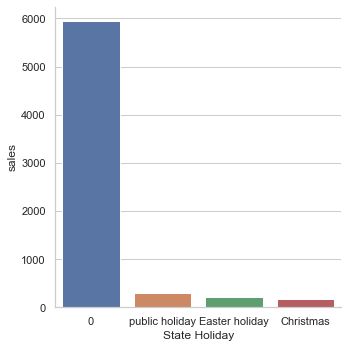

In [52]:
rs = conn.execute("""SELECT StateHoliday, AVG(Sales) as mean_sales FROM sales
                    Group By StateHoliday
                    ORDER BY mean_sales DESC""")
results = rs.fetchall()

sns.catplot(data=pd.DataFrame(results), x = 0, y = 1, kind = 'bar')
plt.xlabel('State Holiday')
plt.ylabel('sales');

Above visualization shows that sales on holidays are much lower than other days. Obviously, this makes sense given that Rossman sells medicines.

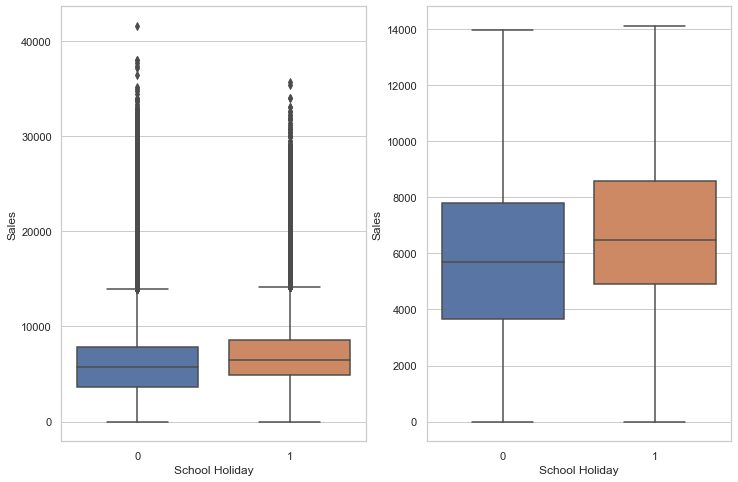

In [53]:
results = conn.execute(""" SELECT SchoolHoliday, Sales FROM sales
                            WHERE StateHoliday = 0""").fetchall()

fig, axes = plt.subplots(nrows =1, ncols = 2, figsize = (12,8))

sns.boxplot(ax = axes[0],data = pd.DataFrame(results), x = 0, y = 1)
sns.boxplot(ax = axes[1],data = pd.DataFrame(results), x = 0, y = 1, showfliers = False)
for ax in axes.flat:
    ax.set(xlabel='School Holiday', ylabel='Sales');

School holidays show a different story however (leaving out state holidays, as we already know these differ). It seems sales figures for school holidays and non-school holidays are rather similar, with school holidays having slightly higher sales with less spread.

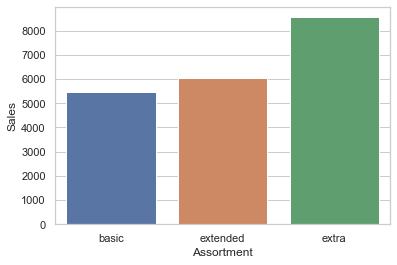

In [54]:
results = conn.execute("""SELECT Assortment, AVG(Sales) as mean_sales
                    FROM sales
                    LEFT JOIN stores
                    USING (Store)
                    GROUP BY Assortment""").fetchall()
sns.barplot(data=pd.DataFrame(results), x = 0, y = 1)
plt.xlabel('Assortment')
plt.ylabel('Sales');

It seems that stores with extended and extra assortment make more sales, which is not that surprising. Let's see if it is worth turning basic stores into extended ones (without really taking into account extra costs as I don't have that data):

In [55]:
results = conn.execute("""SELECT Assortment, Sales FROM sales
                            LEFT JOIN stores
                            USING (Store)""").fetchall()

In [56]:
results_df = pd.DataFrame(results, columns = ['assortment','sales'])

In [57]:
focus = results_df[results_df.assortment =='extended']['sales']
compare = results_df[results_df.assortment == 'basic']['sales']

T, p = stests.ztest(focus, compare,alternative='two-sided')
print('p value: ',p)

if p <0.05: print('Mean sales of extended stores are higher than of basic stores') 

p value:  0.0
Mean sales of extended stores are higher than of basic stores


We can indeed say that, based purely on sales, extending the assortment is worth it. However, there are other factors of course, like costs, location, and whether or not there are other Rossman stores closeby.

It seems Rossmann applies promos only for certain stores. Let's see if this difference in sales is statistical significant as well: 

In [58]:
results = conn.execute("""SELECT sales, promo FROM sales
                            LEFT JOIN stores
                            USING (store)""").fetchall()


In [59]:
results_df = pd.DataFrame(results, columns = ['sales','promo'])
results_df.groupby('promo')['sales'].mean()

promo
0    4406.050805
1    7991.152046
Name: sales, dtype: float64

In [60]:
promo_sales = results_df[results_df.promo ==1]['sales']
norm_sales = results_df[results_df.promo ==0]['sales']

T, p = stests.ztest(promo_sales, norm_sales,alternative='two-sided')

if p < 0.05: print('P value: {}\nAverage sales with promo are higher than without promo'.format(p))

P value: 0.0
Average sales with promo are higher than without promo


It seems stores with promos have higher average sales. However, if this is due to the promos is not clear, as it could be due to reasons why promos are only applied there in the first place.

#### 5. Time-series analysis

Now, let's look at sales patterns over time:

In [61]:
results = conn.execute("""SELECT AVG(Sales), Date FROM Sales
                            GROUP BY Date""").fetchall()

<AxesSubplot:xlabel='date'>

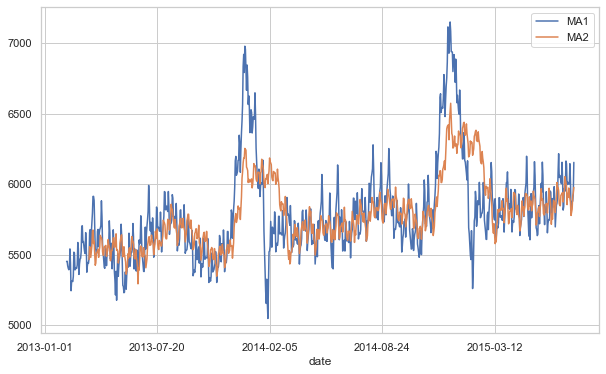

In [62]:
results_df = pd.DataFrame(results, columns = ['sales','date'])
results_df.set_index('date', inplace = True)

results_df['MA1'] = results_df['sales'].rolling(window=40).mean()
results_df['MA2'] = results_df['sales'].rolling(window=80).mean()

results_df[['MA1','MA2']].plot(figsize=(10, 6))

The graph above pictures the moving averages (40 days, 80 days) of sales. We see two interesting things: (1) there appears to be a improving trend over all, and (2) it shows some seasonality effects.

Let's compare year by year to zoom in on this seasonality:

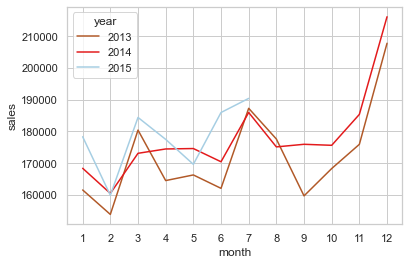

In [63]:
results_df = pd.DataFrame(results, columns = ['sales','date'])
results_df.date = pd.to_datetime(results_df.date)
results_df['year'] = results_df.date.dt.year
results_df['month'] = results_df.date.dt.month
sns.lineplot(data = results_df, x = 'month', y = 'sales', hue = 'year', estimator = sum, ci = None, palette = 'Paired_r')
plt.xticks(np.arange(1,13,1));

Looking at the sales figures over the three years, we notice some recurrent patterns. The three years show very similar developments with certain months falling down and others increasing. Especially towards the end of the year.